# Particle Filter

## Code for robot spawn, move and sense

In [2]:
# In this exercise, try to write a program that
# will resample particles according to their weights.
# Particles with higher weights should be sampled
# more frequently (in proportion to their weight).

# Don't modify anything below. Please scroll to the 
# bottom to enter your code.

from math import *
import random

landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')      
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0;
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

## Task 1

In this case, all noise parameters are 0

In [3]:
# starts at 30.0, 50.0, heading north (=pi/2)
# turns clockwise by pi/2, moves 15 meters
# senses
# turns clockwise by pi/2, moves 10 meters
# senses


In [4]:
my_robot = robot()
my_robot.set(30.,50.,pi/2)
my_robot = my_robot.move(-pi/2, 15)
print(f"Landmarks at: {my_robot.sense()}")
my_robot = my_robot.move(-pi/2, 10)
print(f"Landmarks at: {my_robot.sense()}")
print(f"Robot at {my_robot}")

Landmarks at: [39.05124837953327, 46.09772228646444, 39.05124837953327, 46.09772228646444]
Landmarks at: [32.01562118716424, 53.150729063673246, 47.16990566028302, 40.311288741492746]
Robot at [x=45.0 y=40.0 orient=4.7123]


## Task 2
Adding noise parameters

In [5]:
# forward_noise = 5.0, turn_noise = 0.1, sense_noise = 5.0
# rest is same as task 1
# starts at 30.0, 50.0, heading north (=pi/2)
# turns clockwise by pi/2, moves 15 meters
# senses
# turns clockwise by pi/2, moves 10 meters
# senses

In [6]:
f_noise = 5.0
t_noise = 0.1
s_noise = 5.0

In [7]:
my_robot = robot()
my_robot.set(30.,50.,pi/2)
# adding noise parameters
my_robot.set_noise(f_noise, t_noise, s_noise)
my_robot = my_robot.move(-pi/2, 15)
print(f"Landmarks at: {my_robot.sense()}")
my_robot = my_robot.move(-pi/2, 10)
print(f"Landmarks at: {my_robot.sense()}")
print(f"Robot at {my_robot}")

Landmarks at: [36.92849781893767, 48.95026438734856, 36.43555193578443, 35.21508252005697]
Landmarks at: [41.49912262432008, 51.28315502726264, 55.05904610287779, 28.30789961037947]
Robot at [x=50.352 y=35.697 orient=4.7463]


## Create particles

In [8]:
N = 1000
# create n particles

particles = [robot() for i in range(N)]

len(particles)

1000

## Move particles

In [9]:
# turn by 0.1 , and move by 5
p_moved = [x.move(0.1, 5) for x in particles]

In [10]:
particles[0], p_moved[0]

([x=58.897 y=5.3789 orient=0.9279], [x=61.480 y=9.6602 orient=1.0279])

## Task 3

Make weights to assign each particle where  
> $weights \propto$ error b/w predicted location of landmarks from particle, and actual measurement

In [11]:
print("Robot at: ",my_robot)
z = my_robot.sense()
print(f"Measurement of landmarks by robot: {z}")

Robot at:  [x=50.352 y=35.697 orient=4.7463]
Measurement of landmarks by robot: [28.577440170299745, 49.948024957547545, 52.48209215902547, 35.44330543886293]


In [12]:
## again create particles, but this time, set noise (otherwise measurement prob will return error)
N = 1000
# create n particles

particles = [robot() for i in range(N)]
_ = [x.set_noise(0.05, 0.05, 5.0) for x in particles]
len(particles)

1000

In [13]:
# turn by 0.1 , and move by 5
particles = [x.move(0.1, 5) for x in particles]

In [14]:
particles

[[x=40.645 y=55.198 orient=1.6683],
 [x=42.707 y=67.722 orient=6.2820],
 [x=35.420 y=7.1807 orient=1.7887],
 [x=86.898 y=71.516 orient=0.4634],
 [x=17.901 y=49.628 orient=1.0794],
 [x=62.753 y=8.2969 orient=6.0049],
 [x=41.215 y=73.964 orient=0.2422],
 [x=38.398 y=63.693 orient=4.1463],
 [x=8.8218 y=58.778 orient=4.1592],
 [x=57.640 y=83.911 orient=3.9081],
 [x=14.582 y=12.570 orient=3.9663],
 [x=6.3623 y=45.756 orient=2.0853],
 [x=68.126 y=1.3547 orient=3.5885],
 [x=77.012 y=35.171 orient=3.6596],
 [x=50.168 y=84.610 orient=1.2656],
 [x=59.937 y=25.238 orient=4.6387],
 [x=91.776 y=30.817 orient=4.3196],
 [x=43.402 y=29.238 orient=3.4228],
 [x=18.815 y=90.015 orient=2.5383],
 [x=14.505 y=48.566 orient=2.4587],
 [x=80.368 y=8.8239 orient=3.9972],
 [x=11.738 y=22.794 orient=2.1278],
 [x=86.799 y=86.357 orient=1.3389],
 [x=30.984 y=35.582 orient=3.6567],
 [x=53.075 y=66.168 orient=2.2639],
 [x=78.761 y=84.831 orient=3.3938],
 [x=83.190 y=27.676 orient=3.8876],
 [x=83.177 y=8.3997 orient=0

In [15]:
particles[0].forward_noise,particles[0].turn_noise,particles[0].sense_noise

(0.05, 0.05, 5.0)

In [16]:
probs_unnorm = [x.measurement_prob(z) for x in particles]
probs_unnorm

[1.1012816521350475e-12,
 6.91381522733006e-23,
 7.006194349402724e-22,
 9.329279912879245e-50,
 3.2787467211849765e-22,
 2.162544763205123e-22,
 5.106871584327225e-30,
 1.4027280470861128e-20,
 1.3731242559069762e-36,
 1.573558033789916e-40,
 3.2124816019028383e-35,
 1.8031767981355723e-31,
 1.398813448596049e-32,
 2.4802173196008452e-20,
 1.211747710705197e-39,
 7.909729393211736e-11,
 1.3791083129498865e-35,
 9.404025495804022e-07,
 1.1350603751549563e-65,
 1.5534866243983591e-24,
 5.415987817035824e-38,
 1.8250214584695291e-31,
 3.651321600172532e-67,
 8.494258136838733e-11,
 1.2917714683498062e-20,
 1.053170537658388e-60,
 7.661517895452113e-30,
 4.3567342009617595e-41,
 1.092666357755451e-60,
 3.1551349025158957e-37,
 1.4174620666140855e-58,
 1.752344396676883e-46,
 2.86919188240919e-19,
 3.0731959425578214e-33,
 6.164495365047907e-35,
 7.226936536857823e-19,
 3.2000676826491562e-15,
 4.632120225113556e-29,
 2.96133392134873e-43,
 3.4270657332821343e-38,
 6.481269412315876e-13,
 

In [17]:
probs_unnorm_tot = sum(probs_unnorm)
probs = [x/probs_unnorm_tot for x in probs_unnorm]

## Sample particles (with replacement), using the prob. dist obtained

In [20]:
import matplotlib.pyplot as plt

%matplotlib inline

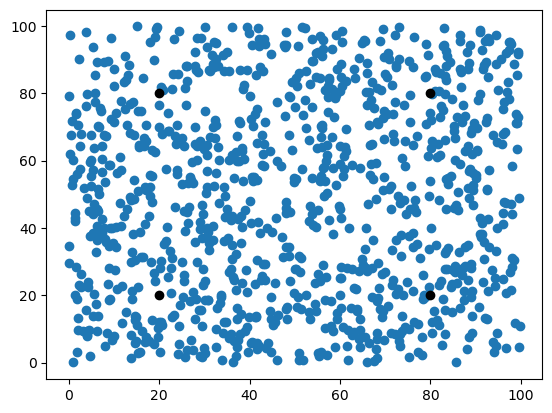

In [21]:
p_x, p_y = [p.x for p in particles], [p.y for p in particles]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y)
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

Here the number of particles is kept constant

### My method

In [22]:
p_new = []
added_indices = set()
while(len(p_new) < 1000):
    i = random.randint(0,N-1)
    if (random.random() < probs[i]):
        p_new.append(particles[i])
        added_indices.add(i)
    

In [23]:
p_new[i]

[x=48.151 y=34.350 orient=0.6153]

In [24]:
len(added_indices)

34

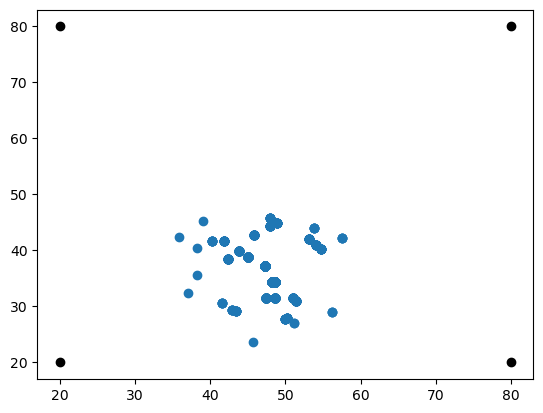

In [25]:
p_x, p_y = [p.x for p in p_new], [p.y for p in p_new]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y)
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

### Thrun method (Roulette Sampling)
Tried to implement by self

In [26]:
p_new = []

index = random.randint(0,N-1) # sample an index uniformly
beta = 0
probs_max = max(probs)
for i in range(N):
    beta += 2 * probs_max # step is wrong
    picked = False
    while not picked:
        if probs[index] < beta:
            beta -= probs[index]
            index = (index + 1) % N
        else:
            p_new.append(particles[index])
            picked = True
        

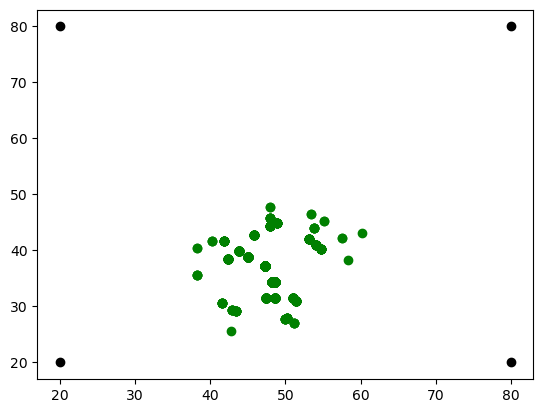

In [27]:
p_x, p_y = [p.x for p in p_new], [p.y for p in p_new]
# fig, ax = plt.subplots()
plt.scatter(p_x, p_y, color='g')
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

### Thrun Actual Roulette Implementation

In [28]:
p_new = []

index = random.randint(0,N-1) # sample an index uniformly
beta = 0
probs_max = max(probs)
for i in range(N):
    beta += random.random() * 2 * probs_max
    while probs[index] < beta:
        beta -= probs[index]
        index = (index + 1) % N
    p_new.append(particles[index])
        

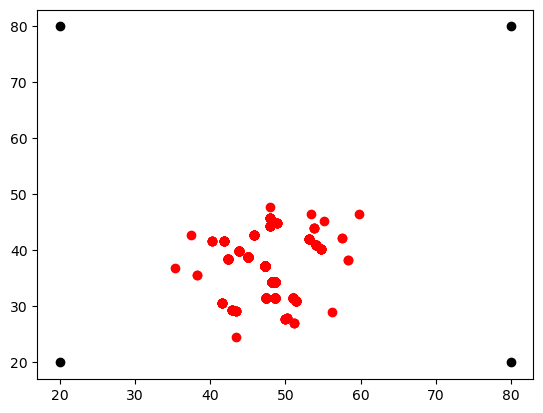

In [29]:
p_x, p_y = [p.x for p in p_new], [p.y for p in p_new]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y, color='r')
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

## Task 4

Run the loop twice

In [30]:
def filter_loop(N,motions, my_robot):
    # N = 1000
    # create n particles
    
    particles = [robot() for i in range(N)]
    _ = [x.set_noise(0.05, 0.05, 5.0) for x in particles]
    for i in range(len(motions)):
        my_robot = my_robot.move(motions[i][0], motions[i][1]) 
        particles = [x.move(motions[i][0], motions[i][1]) for x in particles]
        z = my_robot.sense()
        probs_unnorm = [x.measurement_prob(z) for x in particles]
        probs_unnorm_tot = sum(probs_unnorm)
        probs = [x/probs_unnorm_tot for x in probs_unnorm]

        # resample particles
        p_new = []
        index = random.randint(0,N-1) # sample an index uniformly
        beta = 0
        probs_max = max(probs)
        for j in range(N):
            beta += random.random() * 2 * probs_max
            while probs[index] < beta:
                beta -= probs[index]
                index = (index + 1) % N
            p_new.append(particles[index])
        particles = p_new
        print(i,perf_eval(my_robot, particles))
    return particles
        

In [31]:
# motions = [[0.1,5.0], [0.1, 5.0], [0.1,5.0]]
motions = [[0.1,5.0]] * 10
my_robot = robot()
# my_robot.set_noise(f_noise, t_noise, s_noise)
particles = filter_loop(1000, motions, my_robot)

NameError: name 'perf_eval' is not defined

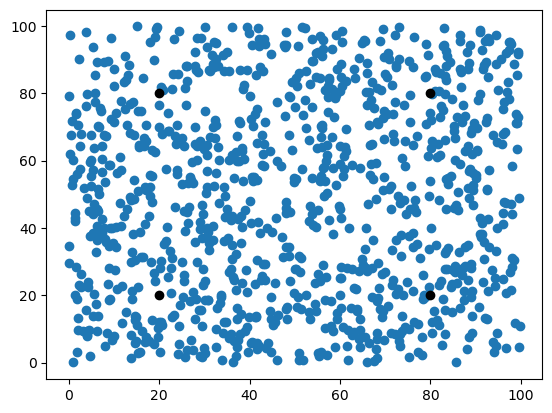

In [32]:
p_x, p_y = [p.x for p in particles], [p.y for p in particles]
fig, ax = plt.subplots()
plt.scatter(p_x, p_y)
for x,y in landmarks:
    plt.scatter(x, y, color="black", marker="o")
plt.show();

In [33]:
particles

[[x=40.645 y=55.198 orient=1.6683],
 [x=42.707 y=67.722 orient=6.2820],
 [x=35.420 y=7.1807 orient=1.7887],
 [x=86.898 y=71.516 orient=0.4634],
 [x=17.901 y=49.628 orient=1.0794],
 [x=62.753 y=8.2969 orient=6.0049],
 [x=41.215 y=73.964 orient=0.2422],
 [x=38.398 y=63.693 orient=4.1463],
 [x=8.8218 y=58.778 orient=4.1592],
 [x=57.640 y=83.911 orient=3.9081],
 [x=14.582 y=12.570 orient=3.9663],
 [x=6.3623 y=45.756 orient=2.0853],
 [x=68.126 y=1.3547 orient=3.5885],
 [x=77.012 y=35.171 orient=3.6596],
 [x=50.168 y=84.610 orient=1.2656],
 [x=59.937 y=25.238 orient=4.6387],
 [x=91.776 y=30.817 orient=4.3196],
 [x=43.402 y=29.238 orient=3.4228],
 [x=18.815 y=90.015 orient=2.5383],
 [x=14.505 y=48.566 orient=2.4587],
 [x=80.368 y=8.8239 orient=3.9972],
 [x=11.738 y=22.794 orient=2.1278],
 [x=86.799 y=86.357 orient=1.3389],
 [x=30.984 y=35.582 orient=3.6567],
 [x=53.075 y=66.168 orient=2.2639],
 [x=78.761 y=84.831 orient=3.3938],
 [x=83.190 y=27.676 orient=3.8876],
 [x=83.177 y=8.3997 orient=0

## Evaluate

In [34]:
def perf_eval(my_robot, particles):
    sum = 0.0
    for i,p in enumerate(particles):
        dx = (p.x - my_robot.x + world_size/2) % world_size - (world_size/2) # dist calc in cyclic world
        dy = (p.y - my_robot.y + world_size/2) % world_size - (world_size/2)
        error = sqrt(dx**2 + dy**2) # euclidean error
        sum += error
    # return avg error
    return sum / len(particles)
    